<a href="https://colab.research.google.com/github/DavidTatis/HyperParameter-Tunning/blob/main/GridSearch_DNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example of a NN for MNIST
Source:https://www.kaggle.com/prashant111/mnist-deep-neural-network-with-keras

Libreries

In [ ]:
!pip install scikeras[tensorflow]
!pip install scikeras[tensorflow-cpu]

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # plotting library
%matplotlib inline


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation, Dropout,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras import  backend as K
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier


Dataset

In [2]:
# import dataset
from tensorflow.keras.datasets import mnist

# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()


# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))


# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


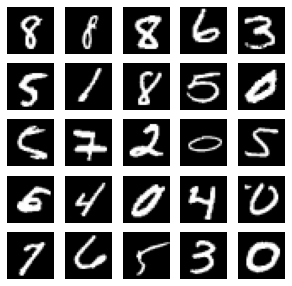

In [3]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

Model:

 Import Keras layers

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

One-hot encoding

In [5]:
num_labels = len(np.unique(y_train))
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Preprocessing data

In [6]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
print(input_size)
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

784


Network parameters

In [7]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

In [8]:
def create_model(num_layers=2,hidden_units_start=256,activation='relu'):
  model2 = Sequential()
  model2.add(Dense(hidden_units_start, input_dim=input_size))
  model2.add(Activation(activation))
  model2.add(Dropout(dropout))
  for layer in range(num_layers-1):
    model2.add(Dense(hidden_units_start))
    model2.add(Activation(activation))
    model2.add(Dropout(dropout))
  
  model2.add(Dense(num_labels))
  model2.add(Activation('softmax'))
  model2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
  return model2




In [21]:
# create model
model = KerasClassifier(build_fn=create_model,activation='softmax', hidden_units_start=64,epochs=10,num_layers=3, batch_size=batch_size, verbose=0)
# define the grid search parameters
num_layers = [2,3,4]
hidden_units_start = [128,256,512]
activation=['relu','tanh','sigmoid']
param_grid = dict(num_layers=num_layers,hidden_units_start=hidden_units_start,activation=activation)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,scoring='accuracy')
grid_result = grid.fit(x_train, y_train)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 activation_8 (Activation)   (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 10)               

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


In [22]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.978017 using {'activation': 'relu', 'hidden_units_start': 512, 'num_layers': 2}


In [51]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Results sorted by mean(CV) of accuracy:\n")
sort_res=sorted(zip((round(elem, 4) for elem in means),
                    (round(elem, 4) for elem in stds),
                    params), key=lambda item: item[0],reverse=True)
for  elem in sort_res:
  print(elem,"\n")


Results sorted by mean(CV) of accuracy:

(0.978, 0.0012, {'activation': 'relu', 'hidden_units_start': 512, 'num_layers': 2}) 

(0.9773, 0.0027, {'activation': 'relu', 'hidden_units_start': 512, 'num_layers': 3}) 

(0.9764, 0.0014, {'activation': 'relu', 'hidden_units_start': 512, 'num_layers': 4}) 

(0.9763, 0.0017, {'activation': 'relu', 'hidden_units_start': 256, 'num_layers': 2}) 

(0.9752, 0.0016, {'activation': 'relu', 'hidden_units_start': 256, 'num_layers': 3}) 

(0.974, 0.0023, {'activation': 'relu', 'hidden_units_start': 256, 'num_layers': 4}) 

(0.9714, 0.0021, {'activation': 'tanh', 'hidden_units_start': 512, 'num_layers': 2}) 

(0.9707, 0.002, {'activation': 'relu', 'hidden_units_start': 128, 'num_layers': 2}) 

(0.9704, 0.0021, {'activation': 'sigmoid', 'hidden_units_start': 512, 'num_layers': 2}) 

(0.9692, 0.003, {'activation': 'sigmoid', 'hidden_units_start': 512, 'num_layers': 3}) 

(0.969, 0.0023, {'activation': 'sigmoid', 'hidden_units_start': 512, 'num_layers': 4}) 

In [ ]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)

In [ ]:
predictions=model.predict(x_test)

In [ ]:
for  i in range(10):
  print(np.argmax(predictions[i]),np.argmax(y_test[i]))
  # plt.imshow(np.reshape(x_test[i],(28,28)), interpolation='nearest')
  # plt.show()

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9
